In [2]:
import keras
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import json
from keras_preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras import layers, regularizers, optimizers

Using TensorFlow backend.


In [3]:
TRAIN_PATH = 'data/attributes/train.csv'
TEST_PATH = 'data/attributes/test.csv'
FULL_PATH = 'data/attributes/flags.csv'
IMG_PATH = 'data/flags_png'
cols = ['name', 'red', 'green', 'blue', 'gold', 'white', 'black', 'orange', 'crescent', 'triangle', 'icon', 'animate', 'text']

In [4]:
train_df = pd.read_csv(
    TRAIN_PATH, 
    header=None, 
    usecols=[0, 10, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27],
    names=cols)
test_df = pd.read_csv(
    TEST_PATH, 
    header=None, 
    usecols=[0, 10, 11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27],
    names=cols)
countries_json_path = 'data/countries.json'
countries = open(countries_json_path, 'r')
countries_str = countries.read()
countries_map = json.loads(countries_str)
filename_map = {}
reverse_map = {}
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)
for k, v in countries_map.items():
    fname = k.lower() + '.png'
    filename_map[v] = fname
    reverse_map[fname] = v
train_df['name'] = train_df['name'].apply(lambda x: filename_map[x])
test_df['name'] = test_df['name'].apply(lambda x: filename_map[x])



In [5]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_ds = datagen.flow_from_dataframe(
    train_df,
    directory=IMG_PATH,
    x_col='name',
    y_col=cols[1:],
    batch_size=16,
    seed=803,
    shuffle=True,
    class_mode='raw',
    target_size=(250, 125)
)
test_ds = test_datagen.flow_from_dataframe(
    test_df,
    directory=IMG_PATH,
    x_col='name',
    y_col=cols[1:],
    batch_size=16,
    seed=803,
    shuffle=True,
    class_mode='raw',
    target_size=(250, 125)
)

Found 49 validated image filenames.
Found 135 validated image filenames.


In [6]:
model_v1 = Sequential([
    layers.Conv2D(32, 3, padding='same', input_shape=(250, 125, 3), activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(12, activation='sigmoid')
])
model_v1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 125, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 62, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 62, 64)       18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 62, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 31, 128)      

In [7]:
model_v1.compile(optimizers.SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_TEST=test_ds.n//test_ds.batch_size
model_v1.fit_generator(generator=train_ds,
                    validation_data=test_ds,
                    epochs=30
)

Epoch 1/30
4/4 [==============================] - 7s 2s/step - loss: 0.6918 - accuracy: 0.5510 - val_loss: 0.6887 - val_accuracy: 0.6685
Epoch 2/30
4/4 [==============================] - 7s 2s/step - loss: 0.6861 - accuracy: 0.6667 - val_loss: 0.6832 - val_accuracy: 0.7352
Epoch 3/30
4/4 [==============================] - 7s 2s/step - loss: 0.6844 - accuracy: 0.7160 - val_loss: 0.6777 - val_accuracy: 0.7494
Epoch 4/30
4/4 [==============================] - 7s 2s/step - loss: 0.6759 - accuracy: 0.7279 - val_loss: 0.6703 - val_accuracy: 0.7494
Epoch 5/30
4/4 [==============================] - 7s 2s/step - loss: 0.6703 - accuracy: 0.7211 - val_loss: 0.6572 - val_accuracy: 0.7506
Epoch 6/30
4/4 [==============================] - 7s 2s/step - loss: 0.6609 - accuracy: 0.7483 - val_loss: 0.6415 - val_accuracy: 0.7500
Epoch 7/30
4/4 [==============================] - 7s 2s/step - loss: 0.6530 - accuracy: 0.7483 - val_loss: 0.6564 - val_accuracy: 0.7407
Epoch 8/30
4/4 [=========================

In [14]:
test_ds.reset()
pred = model_v1.predict_generator(test_ds, verbose=1)

pred_bool = (pred > 0.5)
predictions = pred_bool.astype(int)

results = pd.DataFrame(predictions, columns=cols[1:])
results["name"] = test_ds.filenames
ordered_cols = ["name"] + cols[1:]
results = results[ordered_cols]
results['name'] = results['name'].apply(lambda x: reverse_map[x])
results.to_csv("results.csv",index=False)

9/9 [==============================] - 3s 281ms/step


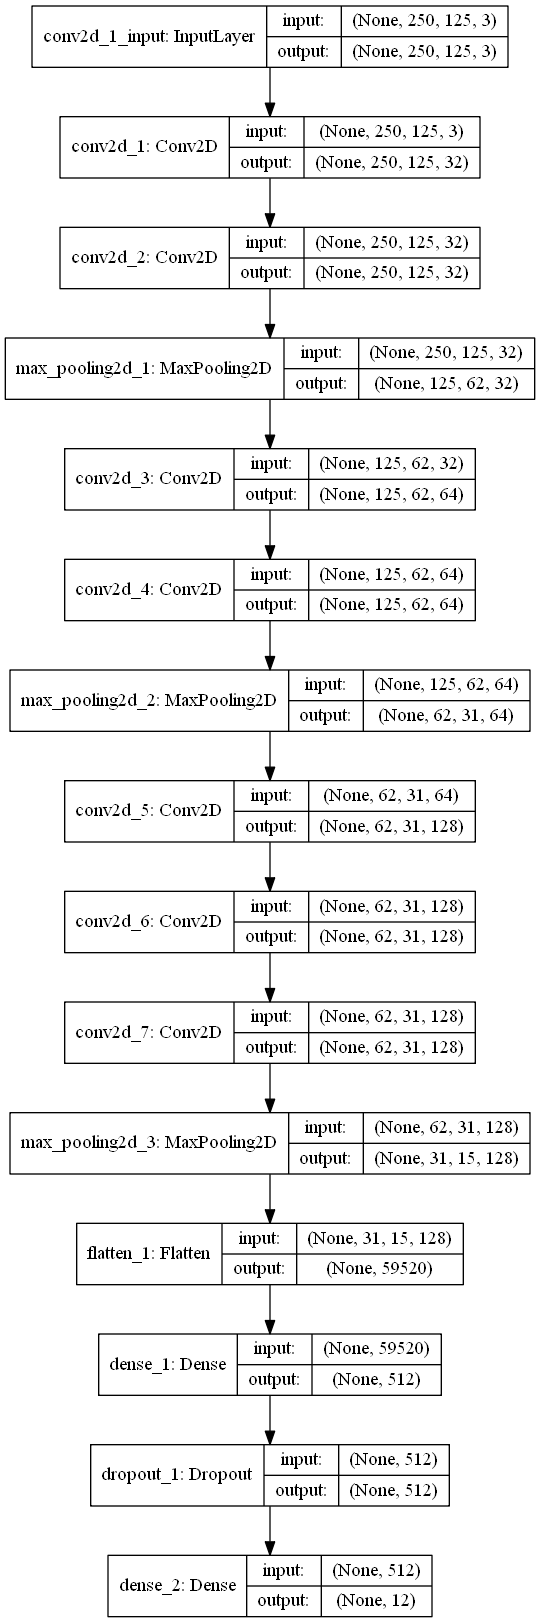

In [11]:
keras.utils.plot_model(model_v1, to_file='cnn_model_v1.png', show_shapes=True,)

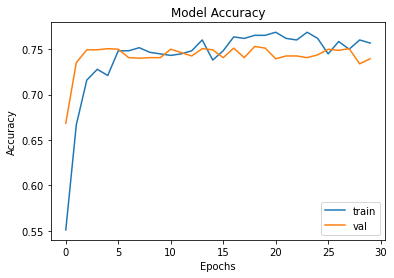

In [16]:
fig, ax = plt.subplots(1, 1)

ax.plot(model_v1.history.history['accuracy'])
ax.plot(model_v1.history.history["val_accuracy"])
ax.set_title("Model {}".format("Accuracy"))
ax.set_xlabel("Epochs")
ax.set_ylabel('Accuracy')
ax.legend(["train", "val"])